# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# Understanding how the income entries are formatted
print "Possible values of income: ", ", ".join(data.income.unique())

Possible values of income:  <=50K, >50K


In [3]:
# Total number of records
n_records = len(data.index)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data.income == ">50K"].index)

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data.income == "<=50K"].index)

# Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k) / float(n_records) * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

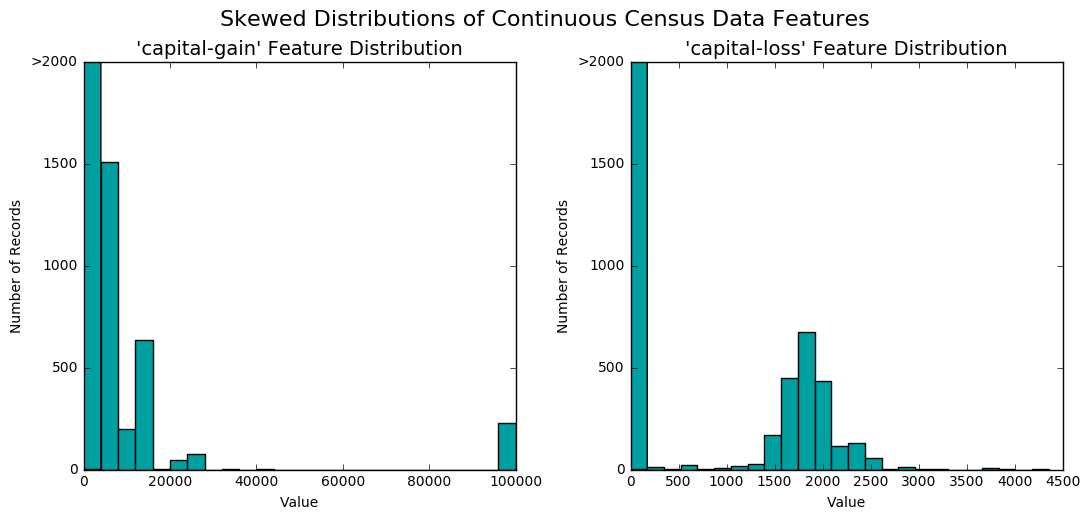

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

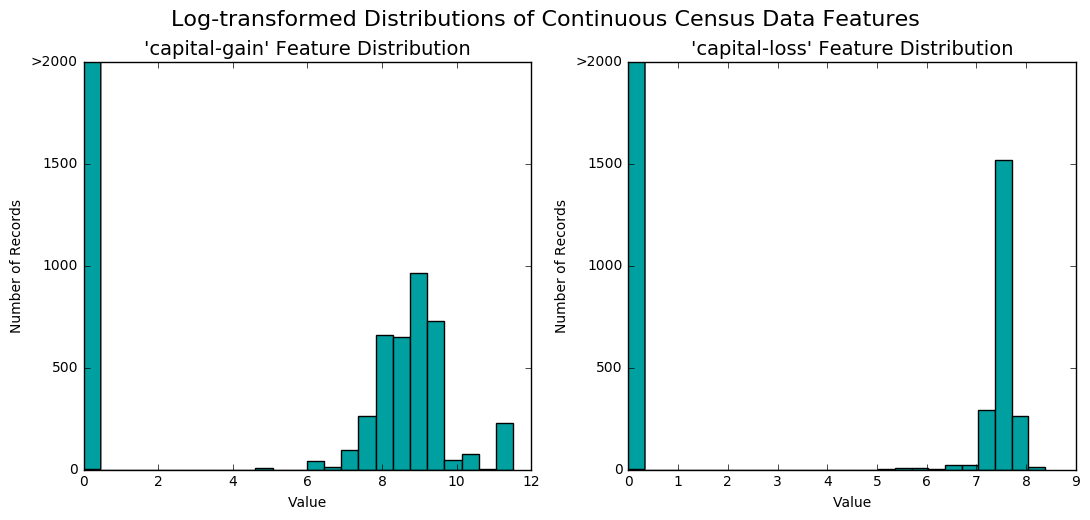

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
print "Before scaling:"
display(data[numerical].head(1))
print "After scaling:"
display(features_raw[numerical].head(n = 1))

Before scaling:


,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13.0,2174.0,0.0,40.0


After scaling:


,age,education-num,capital-gain,capital-loss,hours-per-week
0,0.30137,0.8,0.02174,0.0,0.397959


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# Listing expanded features after one-hot-encoding

encoded_columns = features_raw.select_dtypes(include=["object"]).columns.values
print "Columns that will be one-hot-encoded:", ", ".join(encoded_columns)
print 

for c in encoded_columns:
    print "Possible values for ", c, ": ", ", ".join(features_raw[c].unique())

Columns that will be one-hot-encoded: workclass, education_level, marital-status, occupation, relationship, race, sex, native-country

Possible values for  workclass :   State-gov,  Self-emp-not-inc,  Private,  Federal-gov,  Local-gov,  Self-emp-inc,  Without-pay
Possible values for  education_level :   Bachelors,  HS-grad,  11th,  Masters,  9th,  Some-college,  Assoc-acdm,  7th-8th,  Doctorate,  Assoc-voc,  Prof-school,  5th-6th,  10th,  Preschool,  12th,  1st-4th
Possible values for  marital-status :   Never-married,  Married-civ-spouse,  Divorced,  Married-spouse-absent,  Separated,  Married-AF-spouse,  Widowed
Possible values for  occupation :   Adm-clerical,  Exec-managerial,  Handlers-cleaners,  Prof-specialty,  Other-service,  Sales,  Transport-moving,  Farming-fishing,  Machine-op-inspct,  Tech-support,  Craft-repair,  Protective-serv,  Armed-Forces,  Priv-house-serv
Possible values for  relationship :   Not-in-family,  Husband,  Wife,  Own-child,  Unmarried,  Other-relative
Po

In [8]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = income_raw.replace("<=50K",0).replace(">50K",1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [9]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [10]:
from sklearn.metrics import accuracy_score, fbeta_score

pred = np.ones(n_records)
accuracy = accuracy_score(income, pred)

# Calculate F-score using the formula above for beta = 0.5

# Using sklearn fbeta_score
fscore = fbeta_score(income, pred, 0.5)

# implementing the formula, using sklearn precision and accuracy scores
from sklearn.metrics import recall_score, precision_score
def my_own_fbeta_score(y_true, y_pred, beta):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return ((1.0 + beta*beta) * (precision * recall) / \
            ((beta*beta * precision) + recall))
fscore2 = my_own_fbeta_score(income, pred, 0.5)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score1: {:.4f}, F-score2: {:.4f}]".format(accuracy, fscore, fscore2)

Naive Predictor: [Accuracy score: 0.2478, F-score1: 0.2917, F-score2: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

In [11]:
'''
I added this cell to get an overview of the data in order to help select
the better models to study.
'''

print "Analyzing available features"
print data.describe()
print 
print data.dtypes
print 
print "Conclusion: 5 continuous features, 8 discrete (categorical) features"

'''
# I tried creating 2D histograms to see if there were clear relationships
# between a feature and income. I couldn't find any relationship this way.


import matplotlib.pyplot as plt
for f in features:
    print features[f].dtype
    plt.title(str(f) + " vs Income")
    plt.xlabel(f)
    plt.ylabel("Income > 50K")
    
    if data.dtypes[data.columns.get_loc(str(f).split("_ ")[0])] == "object":
        bins = 2
    else:
        bins = (10, 2)
    
    plt.hist2d(features[f], income, normed=True, bins=bins)
    plt.show()
'''

Analyzing available features
                age  education-num  capital-gain  capital-loss  hours-per-week
count  45222.000000   45222.000000  45222.000000  45222.000000    45222.000000
mean      38.547941      10.118460   1101.430344     88.595418       40.938017
std       13.217870       2.552881   7506.430084    404.956092       12.007508
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       47.000000      13.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain    

'\n# I tried creating 2D histograms to see if there were clear relationships\n# between a feature and income. I couldn\'t find any relationship this way.\n\n\nimport matplotlib.pyplot as plt\nfor f in features:\n    print features[f].dtype\n    plt.title(str(f) + " vs Income")\n    plt.xlabel(f)\n    plt.ylabel("Income > 50K")\n    \n    if data.dtypes[data.columns.get_loc(str(f).split("_ ")[0])] == "object":\n        bins = 2\n    else:\n        bins = (10, 2)\n    \n    plt.hist2d(features[f], income, normed=True, bins=bins)\n    plt.show()\n'

**Answer: **

I chose the following models:

### Gaussian Naive Bayes (GaussianNB)

#### Real World Application

- text retrieval and categorization
- document classification and spam filtering
- automatic medical diagnosis

#### Strengths of the model

- Fast training and prediction time
- Optimal results if features are independent
- No need for parameter tuning

#### Cases when it performs well

- Performs well on classification problems.
- Optimal if target concept falls under a Gaussian Distribution.
- Optimal if the features are independent.
- Optimal if the features are functionally dependent.
- Robust if features' dependencies cancel each other.
- Robust if features' dependencies are spread evenly between classes of features.

#### Weakness of the model 

- In most real-world scenarios features are not truly independent.
- Not a good estimator.
- Zero frequency features can break the model and have to be avoided.

#### Cases when it performs poorly

- Target concept is different from a Gaussian Distribution
- Features are heavily dependent
- Estimation/Regression tasks

#### What makes this model a good candidate for the problem

- This is a classification problem
- GaussianNB is fast to train, predict and require no parameter tuning, which makes it super easy to try out even if the results are not good.

#### References
1. [Wikipedia: Naive Bayes Classifier article](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
2. [Scikit learn Naive Bayes documentation](http://scikit-learn.org/stable/modules/naive_bayes.html)
3. [Rish, Irina (2001). An empirical study of the naive Bayes classifier](http://www.research.ibm.com/people/r/rish/papers/RC22230.pdf)
4. [Zhang, Harry (2004). The Optimality of Naive Bayes](http://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf))
 
 
### Random Forest

#### Real World Application

- MS Xbox Kinect
- Genetics
- Neuroscience

#### Strengths of the model

- Able to handle both numerical and categorical data
- Able to deal with missing and unbalanced data
- Requires little data preparation
- Less bias and variance than a single decision tree
- Less prone to overfitting than a single decision tree

#### Cases when it performs well

- Performs well on classification problems.
- Performs well even if there is few training data available
- Performs well analyzing categorical and numerical data

#### Weakness of the model 

- Not a good estimator.
- Can overfit to noisy data.
- Depending on the complexity of the model, it may have slow prediction times.
- Black box model

#### Cases when it performs poorly

- Performs poorly on estimation and regression tasks
- Performs poorly on problems that demands continuous output
- Performs poorly on complex problems with large random forests tend to make the prediction and training time very slow.
- Performs poorly on problems that need to have their predictions explained.

#### What makes this model a good candidate for the problem

- This is a classification problem
- Decision Trees are the most natural solution to classification problems. Random Forests are Decision Trees on steroids.

#### References



1. [Wikipedia: Random forest article](https://en.wikipedia.org/wiki/Random_forest)
2. [Scikit learn Ensemble Methods documentation](http://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)
3. [Benyamin, Dan (2012). A Gentle Introduction to Random Forests, Ensembles, and Performance Metrics in a Commercial System](https://citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics/)
4. [Shotton, J. et al (2011). Real-Time Human Pose Recognition in Parts from a Single Depth Image](https://www.microsoft.com/en-us/research/publication/real-time-human-pose-recognition-in-parts-from-a-single-depth-image/)
5. [Strobl, C. Zeileis, A. (2008). Why and how to use random forest variable importance measures (and how you shouldn’t)](https://www.statistik.uni-dortmund.de/useR-2008/slides/Strobl+Zeileis.pdf)


### Gradient Boosting

#### Real World Application

- Web search ranking
- Ecology

#### Strengths of the model

- Natural handling of data of mixed type (= heterogeneous features)
- Predictive power
- Robustness to outliers in output space (via robust loss functions)
- Able to handle both numerical and categorical data
- Able to deal with missing and unbalanced data
- Requires little data preparation

#### Cases when it performs well

- Performs well on classification and regression problems.
- Performs well analyzing categorical and numerical data
- Performs well in the presence of outliers

#### Weakness of the model 

- Scalability, due to the sequential nature of boosting it can hardly be parallelized.
- Compared to the Random Forests and GaussianNB:
   - Requires a lot of training data
   - Requires a lot of training time
- Blackbox model
- Loss functions need to be differentiable

#### Cases when it performs poorly

- Performs poorly on problems that need to have their predictions explained.
- Performs poorly on problems with few training data
- Performs poorly on problems that require lots of training (constant shifting training data)

#### What makes this model a good candidate for the problem

- This problem doesn't require multiple trainings.
- Gradient Boosting is a strong candidate for most machine learning problems.

#### References

1. [Wikipedia: Gradient boosting article](https://en.wikipedia.org/wiki/Gradient_boosting)
2. [Scikit learn Ensemble Methods documentation](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)
3. [Li, Cheng. A Gentle Introduction to Gradient Boosting](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf)
4. [Natekin, Alexey and Knoll, Alois (2013). Gradient boosting machines, a tutorial](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/)

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [12]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score
import random

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    sample_rows = np.random.choice(X_train.index.values, size=sample_size, replace=False)
    start = time() # Get start time
    learner = learner.fit(X_train.ix[sample_rows], y_train.ix[sample_rows])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 362 samples.
GaussianNB trained on 3618 samples.
GaussianNB trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 362 samples.
GradientBoostingClassifier trained on 3618 samples.
GradientBoostingClassifier trained on 36177 samples.


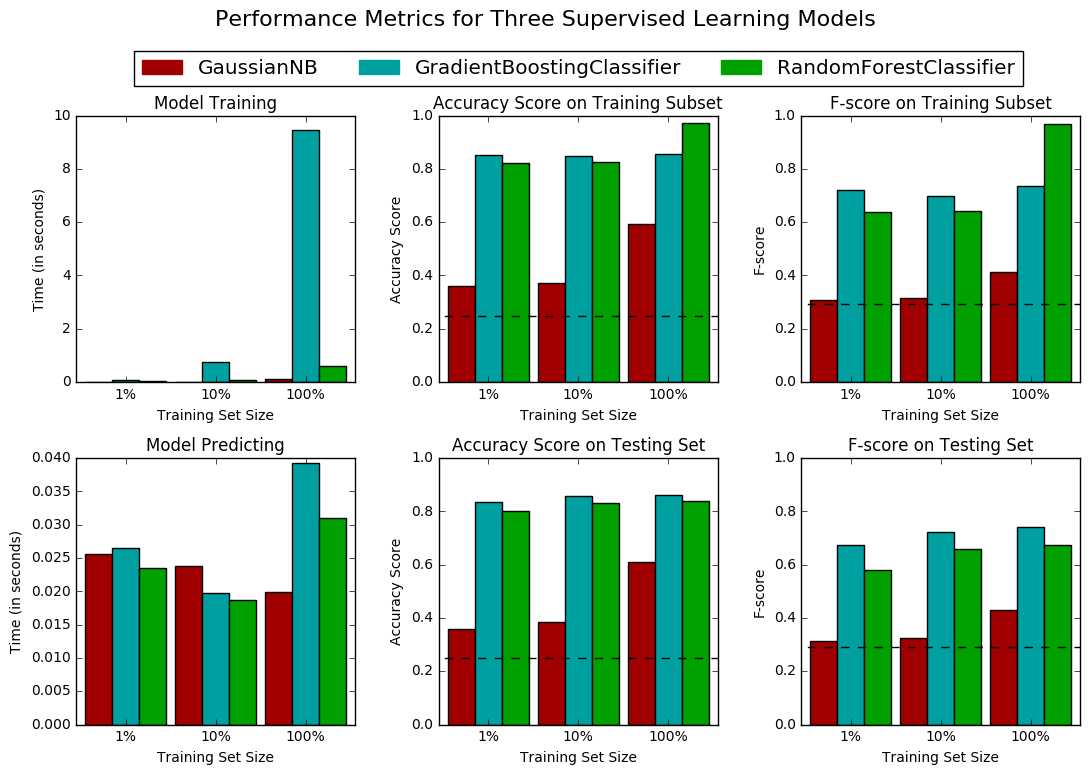

In [13]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state=10)
clf_C = GradientBoostingClassifier(random_state=10)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(X_train.index)
samples_1 = int(round(samples_100 * 0.01))
samples_10 = int(round(samples_100 * 0.1))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [14]:
# Printing exact metrics on test scores with 100% train data
print "Printing exact metrics on test scores with 100% train data"
print

metrics = ["acc_test", "f_test", "f_train", "pred_time", "train_time"]
for model in results:
    print model, dict((k, results[model][2][k]) for k in metrics)
    print


Printing exact metrics on test scores with 100% train data

GaussianNB {'train_time': 0.11288809776306152, 'f_train': 0.41249999999999998, 'pred_time': 0.01985001564025879, 'acc_test': 0.60829187396351581, 'f_test': 0.42811288507232487}

GradientBoostingClassifier {'train_time': 9.47171688079834, 'f_train': 0.73412698412698407, 'pred_time': 0.03931403160095215, 'acc_test': 0.86301824212271971, 'f_test': 0.7395338561802719}

RandomForestClassifier {'train_time': 0.5829079151153564, 'f_train': 0.96726190476190466, 'pred_time': 0.03095698356628418, 'acc_test': 0.83913764510779432, 'f_test': 0.67567567567567566}



----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **



The most suitable model for the task of identifying individuals that make more than \$50,000 is the **Gradient Boosting model.**

We can summary the evaluations done as:

| Model | Train Time (s) | Prediction Time (s) | Accuracy (%) | F-Score (%) |
|-------|------------|-----------------|----------|---------|
|Gaussian Naive Bayes| 0.1161 | 0.0204 | 60.8292 | 42.8113 |
|Gradient Boosting | 9.0198 | 0.0209 | 86.3018| 73.9534 |
|Random Forest | 0.6983 | 0.0374 | 83.9580 | 67.6112 |
<center>*Performance metrics of the models, considering training on 100% of training set*</center>

This table can be explained as:
- **Train time**: required time to prepare the model to a new set of parameters.
- **Prediction time**: required time to output a prediction.
- **Accuracy**: probability of the model prediction being correct, according to the test dataset.
- **F-Score**: is another measure of accuracy that, for this setup, weighs more the predictions correctly identifying donors.

Also note that all models are suitable for this dataset, because they can handle both numerical and categorical data to solve classification problems. 

Given all the information above, it is easy to see that **Gradient Boosting model provides the best Accuracy and F-Score**, with Random Forest model at a close second and Gaussian Naive Bayes model far behind. The only downside of Gradient Boosting model is its required training time, which is not a problem for this project, because the model is being trained on census data that is released annually, and it only takes approximately 9 seconds to finish training. 

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

The **Gradient Boosting model** is a collection of weak models grouped together to create a stronger model. It can be better explained in 5 simple steps:

1. This model starts with the selection of a *weak learner*. A weak learner is any assumption that classifies the data slightly better than random chance (50-50). For example: all employed men over age 40 earn more than \$50,000.
2. Then the model is evaluated. This is done by inputing some labeled samples and evaluating the predictions output. Because the results for the selected sample are known, the performance of the model can be evaluated. For example: many employed women over age 40 also earn more than \$50,000, but are being ignored by the model that only selects men.
3. After evaluating the model, the *boosting* takes place. Boosting is the process of adding more weak learners to correct for the past prediction errors. To select new weak learner to be added, an algorithm called *gradient descent* is used, hence the name *Gradient Boosting*. Continuing the example: the first model predicts all employed men earn more than \$50,000. The second *boosted* model predicts any employed human over age 40 earns more than \$50,000.
4. This process (also known as *training*) repeats until a fixed number of weak learners is added or the model performance reaches an acceptable level.
5. After the training ends, the model is ready to make predictions. This is achieved by feeding the same inputs to all the *weak learners* and computing a weighted sum of their outputs. This weighted sum is the final prediction of the model. Example: all learners cast a vote based on their classification of a given input, and the model weighs all votes with a predefined rule built during the training and outputs the final classification.

For further (and more rigorous) information on this model, please read the paper [Friedman, Jerome H. (1999). Greedy Function Approximation: A Gradient Boosting Machine](http://statweb.stanford.edu/~jhf/ftp/trebst.pdf)

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [15]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Creating scorer
scorer = make_scorer(fbeta_score, beta=0.5)

# Parameter tuning done based on:
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

The tuning below was done based on [this complete guide about tuning Gradient Boosting Machines](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

The guide tunes GBM in three steps:
1. Boosting Parameters (i.e: `n_estimators`, `learning_rate`)
2. Tree-specific Parameters (i.e: `max_depth`, `min_samples_split`)
3. Minimize `learning_rate` to improve robustness

#### Remark
The guide uses a greedy naive assumption that tunes parameters separately in order to reduce the search-space of GridSearchCV. So for each step above, all parameters that are not being tuned by the step are set to well-known constants.

In [16]:
# First step Boosting Parameters: n_estimators, learning_rate

# GBM's well-known parameters
p_max_features = "sqrt"
p_subsample = 0.8
p_max_depth = 8
p_min_samples_split = int(round(0.01*n_records))
p_min_samples_leaf = int(round(0.1*p_min_samples_split))

clf = GradientBoostingClassifier(random_state=10, 
                                 max_features=p_max_features,
                                 subsample=p_subsample,
                                 max_depth=p_max_depth,
                                 min_samples_split=p_min_samples_split,
                                 min_samples_leaf=p_min_samples_leaf)

# Tuning Number of Estimators (trees) and learning rate
parameters = {"n_estimators": range(60, 141, 20), "learning_rate": [0.05, 0.1, 0.15, 0.2]}

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=5, n_jobs=4, iid=False)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Print grid search results
print grid_obj.grid_scores_, grid_obj.best_params_, grid_obj.best_score_
print 

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
clf = GradientBoostingClassifier(random_state=10)
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

[mean: 0.73609, std: 0.00771, params: {'n_estimators': 60, 'learning_rate': 0.05}, mean: 0.73844, std: 0.00737, params: {'n_estimators': 80, 'learning_rate': 0.05}, mean: 0.73950, std: 0.00562, params: {'n_estimators': 100, 'learning_rate': 0.05}, mean: 0.74173, std: 0.00555, params: {'n_estimators': 120, 'learning_rate': 0.05}, mean: 0.74201, std: 0.00618, params: {'n_estimators': 140, 'learning_rate': 0.05}, mean: 0.74197, std: 0.00483, params: {'n_estimators': 60, 'learning_rate': 0.1}, mean: 0.74254, std: 0.00539, params: {'n_estimators': 80, 'learning_rate': 0.1}, mean: 0.74324, std: 0.00731, params: {'n_estimators': 100, 'learning_rate': 0.1}, mean: 0.74637, std: 0.00549, params: {'n_estimators': 120, 'learning_rate': 0.1}, mean: 0.74636, std: 0.00516, params: {'n_estimators': 140, 'learning_rate': 0.1}, mean: 0.74228, std: 0.00473, params: {'n_estimators': 60, 'learning_rate': 0.15}, mean: 0.74195, std: 0.00448, params: {'n_estimators': 80, 'learning_rate': 0.15}, mean: 0.74491,

We can see from above that the best *Boosting Parameters* are:
- `learning_rate`: 0.2
- `n_estimators`: 120

Now we proceed to tuning tree-specific parameters in this order:
1. `max_depth` and `min_samples_split`
2. `min_samples_leaf` and `max_features`

In [17]:
# Step two: Tuning tree-specific parameters (max_depth, min_samples_split)

# Parameters found on previous tuning
p_n_estimators=120
p_learning_rate=0.2

# GBM's well-known parameters
p_max_features = "sqrt"
p_subsample = 0.8
p_min_samples_leaf = int(round(0.1*p_min_samples_split))

clf = GradientBoostingClassifier(random_state=10, 
                                 learning_rate=p_learning_rate,
                                 n_estimators=p_n_estimators,
                                 max_features=p_max_features,
                                 subsample=p_subsample,
                                 min_samples_leaf=p_min_samples_leaf)

# Tuning max_depth and min_samples_split
# p_min_samples_split ~ 452
parameters = {"max_depth": range(5, 16, 2), "min_samples_split": range(400, 1001, 200)}

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=5, n_jobs=4, iid=False)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Print grid search results
print grid_obj.grid_scores_, grid_obj.best_params_, grid_obj.best_score_

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
clf = GradientBoostingClassifier(random_state=10)
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

[mean: 0.74359, std: 0.00276, params: {'min_samples_split': 400, 'max_depth': 5}, mean: 0.74488, std: 0.00317, params: {'min_samples_split': 600, 'max_depth': 5}, mean: 0.74248, std: 0.00350, params: {'min_samples_split': 800, 'max_depth': 5}, mean: 0.74441, std: 0.00464, params: {'min_samples_split': 1000, 'max_depth': 5}, mean: 0.74846, std: 0.00358, params: {'min_samples_split': 400, 'max_depth': 7}, mean: 0.74960, std: 0.00243, params: {'min_samples_split': 600, 'max_depth': 7}, mean: 0.74556, std: 0.00271, params: {'min_samples_split': 800, 'max_depth': 7}, mean: 0.74503, std: 0.00161, params: {'min_samples_split': 1000, 'max_depth': 7}, mean: 0.74775, std: 0.00353, params: {'min_samples_split': 400, 'max_depth': 9}, mean: 0.75156, std: 0.00115, params: {'min_samples_split': 600, 'max_depth': 9}, mean: 0.74822, std: 0.00249, params: {'min_samples_split': 800, 'max_depth': 9}, mean: 0.74790, std: 0.00280, params: {'min_samples_split': 1000, 'max_depth': 9}, mean: 0.74531, std: 0.00

So far, we can see from above that the best *Tree-specific Parameters* are:
- `max_depth`: 9
- `min_samples_split`: 600

Now we proceed to tuning the next tree-specific parameters:
- `min_samples_leaf`
- then `max_features`

In [131]:
# Step two: Tuning tree-specific parameters (min_samples_leaf)

# Parameters found on previous tuning
p_n_estimators=120
p_learning_rate=0.2
p_max_depth=9
p_min_samples_split=600

# GBM's well-known parameters
p_subsample = 0.8

clf = GradientBoostingClassifier(random_state=10, 
                                 learning_rate=p_learning_rate,
                                 n_estimators=p_n_estimators,
                                 max_depth=p_max_depth,
                                 min_samples_split=p_min_samples_split,
                                 max_features=p_max_features,
                                 subsample=p_subsample)

# Tuning max_depth and min_samples_split
# p_min_samples_leaf ~ 45
# sqrt(n_features) ~ 10.
parameters = {"min_samples_leaf": range(30, 71, 10), "max_features": range(5, 16, 2)}


# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=5, n_jobs=4, iid=False)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Print grid search results
print grid_obj.grid_scores_, grid_obj.best_params_, grid_obj.best_score_

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
clf = GradientBoostingClassifier(random_state=10)
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

[mean: 0.73980, std: 0.00321, params: {'max_features': 5, 'min_samples_leaf': 30}, mean: 0.74139, std: 0.00430, params: {'max_features': 5, 'min_samples_leaf': 40}, mean: 0.74230, std: 0.00267, params: {'max_features': 5, 'min_samples_leaf': 50}, mean: 0.73958, std: 0.00585, params: {'max_features': 5, 'min_samples_leaf': 60}, mean: 0.73875, std: 0.00537, params: {'max_features': 5, 'min_samples_leaf': 70}, mean: 0.74587, std: 0.00835, params: {'max_features': 7, 'min_samples_leaf': 30}, mean: 0.74421, std: 0.00392, params: {'max_features': 7, 'min_samples_leaf': 40}, mean: 0.73999, std: 0.00525, params: {'max_features': 7, 'min_samples_leaf': 50}, mean: 0.74116, std: 0.00452, params: {'max_features': 7, 'min_samples_leaf': 60}, mean: 0.73978, std: 0.00467, params: {'max_features': 7, 'min_samples_leaf': 70}, mean: 0.74921, std: 0.00421, params: {'max_features': 9, 'min_samples_leaf': 30}, mean: 0.74869, std: 0.00401, params: {'max_features': 9, 'min_samples_leaf': 40}, mean: 0.74833, 

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:


|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478         |      0.8630       |   0.8691        |
| F-score        |      0.2917         |      0.7395       |   0.7475        |


**Answer: **

The scores from the **optimized model are slightly better than the unoptimized model**: ~.7% in accuracy and ~1.1% in f-score.

The scores from the **optimized model are far better than the naive benchmark predictor**: ~350.73% in accuracy and ~256.26% in f-score.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

In [117]:
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


**Answer:**
1. `age`, because it indicates how much one needs to earn/spend. For instance, a man at his 20's is probably single, studying and may even receive financial aid from his parents, while a man at his 40's is probably working at some senior level job, and maybe with a spouse and kids. Age is frequently a good split to this kind of datasets.
2. `education_level` or `education_num`, because people study to get better jobs. Overall higher level education workers tend to be better paid.
3. `hours-per-week`, because most jobs get paid by hour, so more hours means more income.
4. `workclass`, because different areas of expertise tend to be paid differently.
5. `capital-gain`, because `capital-gain = income - spending`. So the higher the income is, the higher the capital gain tend to be, assuming most people tend to spend the same amount.


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

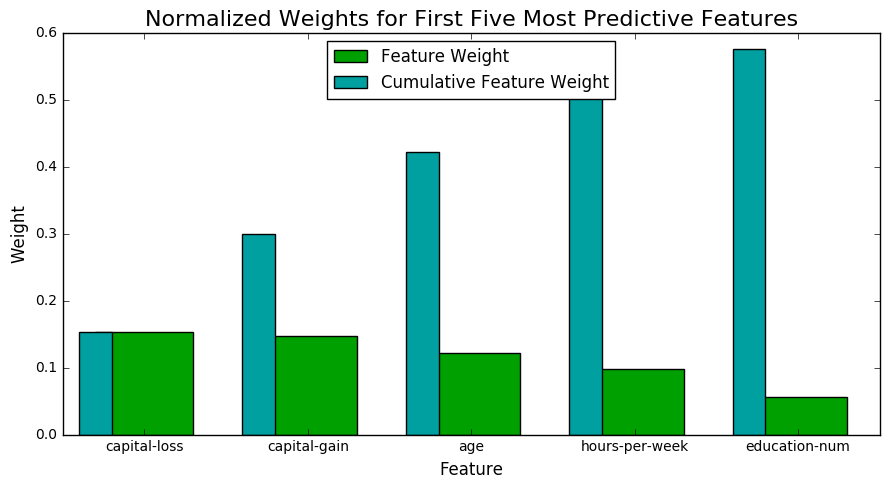

[0.15336576894357909, 0.14638343795953007, 0.1213829864695006, 0.098278361201609321, 0.055670204392172858]


In [124]:
# Import a supervised learning model that has 'feature_importances_'
# I'll be using best_clf (GradientBoostingClassifier trained before) since
# it has the 'feature_importances' attribute.

# Train the supervised model on the training set 
# I'll be using best_clf (GradientBoostingClassifier trained before) since
# it is already fitted to the data.

# Extract the feature importances
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

print sorted(importances, reverse=True)[0:5]

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

The features I listed on question 6 are shown in the visualization, but in different orders. The only exception is the `workclass` feature that I mentioned on question 6, but is not shown in the chart. Instead, the chart shows `capital-loss`. The order I stated on question 6 is pretty different from the chart although.

The visualization showed me that the most important attribute from the dataset is the variation of one's net-worth. This is shown by the two most important features: `capital-loss` and `capital-gain`. Both features tell how much net-worth one lost or gained during the year and this information is directly related to one's income.

Besides these two features, I would say I nailed the features, because I listed `age`, `education-num` and `hours-per-week` as the top three features and the visualization shows them in 3rd, 5th and 4th place respectively. This confirms my reasoning that `age` is, in general, a good split for data and that `hours-per-week` and `education-num` have a direct relationship to income.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [132]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier

# removing max_features paramter, because it most be between 0 and n_features.
# during the tuning, we set it to 13, but now n_features is 5,
# so max_features can't be higher than 5.
clf = (clone(best_clf).set_params(max_features=None)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8691
F-score on testing data: 0.7475

Final Model trained on reduced data
------
Accuracy on testing data: 0.8384
F-score on testing data: 0.6861


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

The final model F-score and accuracy score trained with reduced data were lower than the scores for the same model trained with all features. **Accuracy score decreased by 3.66% and F-score decreased by 8.95%.**

If training time was a *critical* requirement, I would consider using the reduced data as the training set, although I would also consider other approaches (like some other models that take less time to train or parallel and distributed computing using Hadoop, Spark and xgboost).

The tradeoff between training time and scoring must be analyzed with extreme caution, because, while training time might be a critical factor for the whole machine-learning solution, the scoring is directly related to the quality of the final solution.



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.